In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [14]:
test_data = pd.read_pickle('../data/04-0c_Test_Set.pkl')

# Style Embeddings from Style Model

In [15]:
model = StyleModel()
model.load_state_dict(torch.load('../model/TestData_StyleModel.pt'))

<All keys matched successfully>

In [16]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 14235/14235 [03:46<00:00, 62.80it/s]


## Centroids

In [17]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [18]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,Author 1,Author 2,Author 3,Author 4,Author 5,Author 6,Author 7
Author 1,0.000,1.393,1.340,1.280,1.350,1.496,1.288
Author 2,0.000,0.000,1.405,1.348,1.397,1.559,1.368
Author 3,0.000,0.000,0.000,1.298,1.336,1.514,1.305
Author 4,0.000,0.000,0.000,0.000,1.311,1.443,1.235
Author 5,0.000,0.000,0.000,0.000,0.000,1.517,1.300
Author 6,0.000,0.000,0.000,0.000,0.000,0.000,1.467
Author 7,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

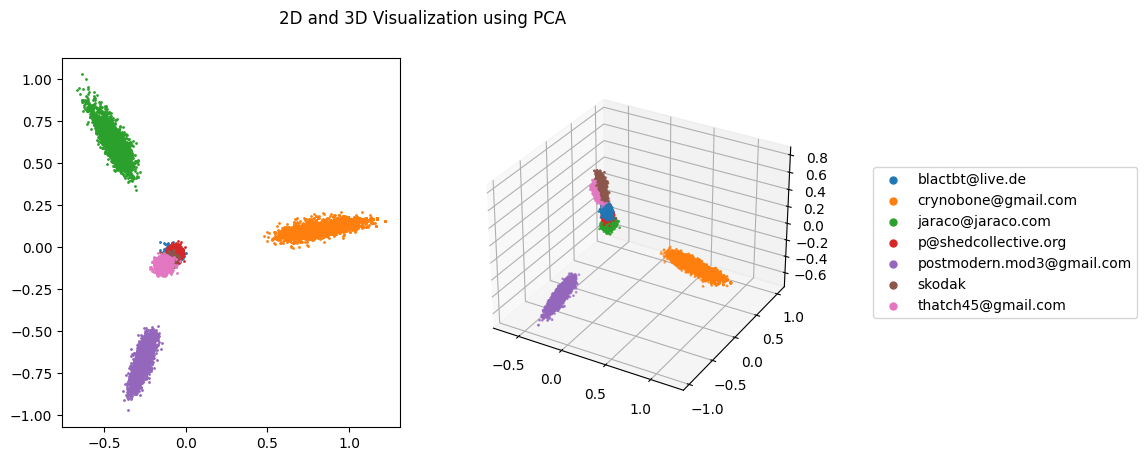

In [19]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

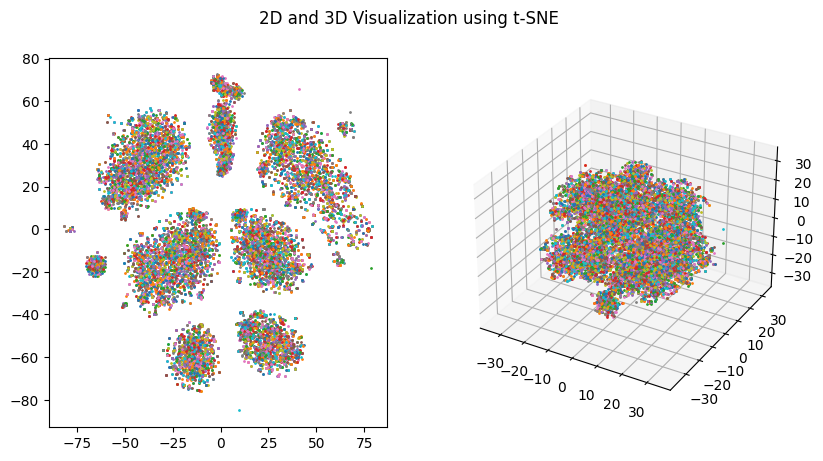

In [20]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, legend= False)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 8
10 Most common:
[(1, 3049), (2, 2896), (4, 2666), (6, 1951), (0, 1359), (5, 1093), (3, 975), (-1, 246)]


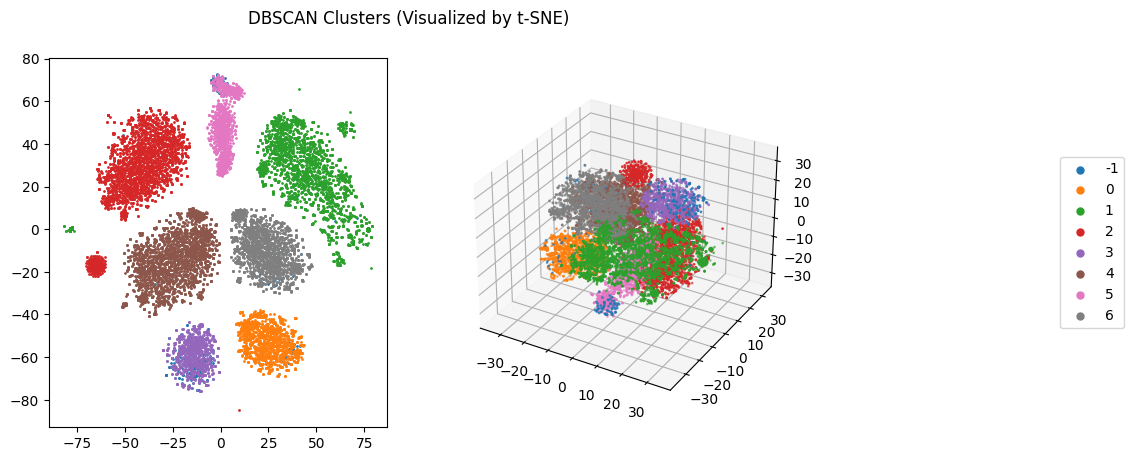

In [21]:
dbscan_model = DBSCAN(eps=0.39, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [22]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 214 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,246.0,7.0,20.0,"('p@shedcollective.org', 128)",29.0,2.0,"('moodle_moodle', 62)"
1,1359.0,1.0,1359.0,"('blactbt@live.de', 1359)",2.0,679.5,"('meew0_discordrb', 1341)"
2,3049.0,1.0,3049.0,"('crynobone@gmail.com', 3049)",74.0,12.5,"('orchestral_foundation', 526)"
3,2896.0,1.0,2896.0,"('jaraco@jaraco.com', 2896)",76.0,8.5,"('pypa_setuptools', 964)"
4,975.0,1.0,975.0,"('p@shedcollective.org', 975)",21.0,13.0,"('nails_common', 411)"
5,2666.0,1.0,2666.0,"('postmodern.mod3@gmail.com', 2666)",37.0,12.0,"('ronin-ruby_ronin', 1334)"
6,1093.0,1.0,1093.0,"('skodak', 1093)",1.0,1093.0,"('moodle_moodle', 1093)"
7,1951.0,1.0,1951.0,"('thatch45@gmail.com', 1951)",1.0,1951.0,"('saltstack_salt', 1951)"


In [23]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,8.000000,8.00000,8.000000,8.000000,8.000000
mean,1779.375000,1.75000,1751.125000,30.125000,471.437500
std,1022.632588,2.12132,1072.927828,30.819463,725.582448
min,246.000000,1.00000,20.000000,1.000000,2.000000
25%,1063.500000,1.00000,1063.500000,1.750000,11.125000
50%,1655.000000,1.00000,1655.000000,25.000000,12.750000
75%,2723.500000,1.00000,2723.500000,46.250000,782.875000
max,3049.000000,7.00000,3049.000000,76.000000,1951.000000


In [24]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5,6,7
length_mean,49.674797,61.948492,31.746474,62.064917,56.514872,54.912228,77.795974,53.296771
length_std,28.788406,35.577672,31.600351,35.066786,25.950437,28.493636,32.599226,36.587896
n_uppercase_mean,2.020325,2.468727,1.716300,2.412638,2.837949,3.108402,11.333943,1.159918
n_uppercase_std,3.030266,2.428131,1.902649,2.411693,3.357715,3.039356,7.071398,1.295045
polarity_mean,0.030691,0.019821,-0.006703,0.013812,-0.009962,0.029075,0.025400,0.026143
polarity_std,0.196725,0.157981,0.129584,0.162258,0.181486,0.142111,0.168986,0.193033
subjectivity_mean,0.210058,0.170744,0.100331,0.141128,0.160589,0.142508,0.209506,0.187402
subjectivity_std,0.298852,0.280475,0.231508,0.247491,0.281215,0.268882,0.241197,0.293745


In [25]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
There's apparently no destructive variation of String.split
___
2) 
Correctly get the reason from the close frame
___
3) 
Fix opcodes 4 and 5 (of course I had to mess something up)
___
4) 
Fix the :italic example command so it actually makes stuff italic and not bold (how did nobody notice this?)
___
5) 
Fix the hoist presence check similarly to mentionable
___
6) 
Apparently I misunderstood what slice! does exactly. Fixed
___
7) 
Fix me breaking the specs during RuboCop fixes (hopefully)
___
8) 
Make load_data_file support loading files from folders
___
9) 
Create a method to create arbitrary snowflakes out of nowhere
___
10) 
Restructure code so I don't get confused
_________________

Number of messages in this class: 246
Most common author:
('p@shedcollective.org', 128)
Most common project:
('moodle_moodle', 62)



________________ Class 1 ________________

___
1) 
Add a role_mentions reader
___
2) 
Add a newline at the end of msgb

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

In [26]:
silhouette_scores = []
k_range = range(3, 15, 1)

for k in k_range:
    kmeans = KMeans(k)
    kmeans_prediction = kmeans.fit_predict(vectors)
    silhouette_scores.append(silhouette_score(vectors, kmeans_prediction))

k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Number of clusters with max silhouette score: {k}")

Number of clusters with max silhouette score: 7


Number of Clusters: 7
10 Most common:
[(4, 3054), (2, 2899), (1, 2669), (3, 1976), (5, 1379), (0, 1155), (6, 1103)]


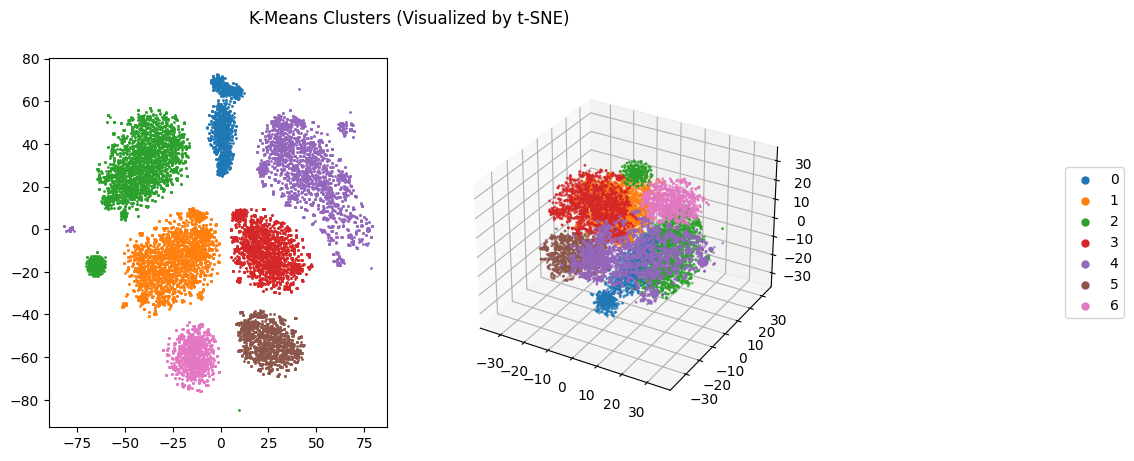

In [27]:
kmeans = KMeans(k)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [28]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 214 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1155.0,1.0,1155.0,"('skodak', 1155)",1.0,1155.0,"('moodle_moodle', 1155)"
1,2669.0,1.0,2669.0,"('postmodern.mod3@gmail.com', 2669)",37.0,12.0,"('ronin-ruby_ronin', 1335)"
2,2899.0,1.0,2899.0,"('jaraco@jaraco.com', 2899)",76.0,8.5,"('pypa_setuptools', 966)"
3,1976.0,1.0,1976.0,"('thatch45@gmail.com', 1976)",1.0,1976.0,"('saltstack_salt', 1976)"
4,3054.0,1.0,3054.0,"('crynobone@gmail.com', 3054)",74.0,12.5,"('orchestral_foundation', 527)"
5,1379.0,1.0,1379.0,"('blactbt@live.de', 1379)",2.0,689.5,"('meew0_discordrb', 1361)"
6,1103.0,1.0,1103.0,"('p@shedcollective.org', 1103)",23.0,12.0,"('nails_common', 470)"


In [29]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.0,7.000000,7.000000,7.000000
mean,2033.571429,1.0,2033.571429,30.571429,552.214286
std,842.974863,0.0,842.974863,33.200688,772.435912
min,1103.000000,1.0,1103.000000,1.000000,8.500000
25%,1267.000000,1.0,1267.000000,1.500000,12.000000
50%,1976.000000,1.0,1976.000000,23.000000,12.500000
75%,2784.000000,1.0,2784.000000,55.500000,922.250000
max,3054.000000,1.0,3054.000000,76.000000,1976.000000


In [30]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,77.197403,54.885350,62.044153,53.101721,31.710544,61.984772,55.019039
length_std,32.857570,28.490110,35.057437,36.422916,31.587448,35.538096,25.824721
n_uppercase_mean,10.863203,3.106032,2.410486,1.159413,1.714800,2.459028,2.749773
n_uppercase_std,7.256010,3.038469,2.411419,1.291279,1.901520,2.417670,3.236092
polarity_mean,0.025526,0.029081,0.013970,0.027701,-0.006692,0.019740,-0.007712
polarity_std,0.175976,0.142041,0.162426,0.193929,0.129478,0.157912,0.177524
subjectivity_mean,0.216529,0.142535,0.141154,0.189413,0.100167,0.171630,0.156708
subjectivity_std,0.248297,0.268849,0.247481,0.295448,0.231354,0.280010,0.277534


In [31]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
MDL-<I> new catgory on modedit available only when outcomes used in course; merged from MOODLE_<I>_STABLE
___
2) 
MDL-<I> allow also numeric string '1' as site id in require_course_login()
___
3) 
MDL-<I> removed isstudent() - yay!
___
4) 
fixed incorrect output buffer use - bug #<I>; merged from MOODLE_<I>_STABLE
___
5) 
a small typo 'helpupload' on /lang/en_utf8/assignment.php MDL-<I>, found by Mitsuhiro Yoshida
___
6) 
Bug #<I> - HTML editor and brackets - fixes lesson problems; merged from MOODLE_<I>_STABLE
___
7) 
MDL-<I> updated license header in installer - completely rewritten for <I>
___
8) 
MDL-<I> allow deleting of all files attached to context
___
9) 
one more sanity check for role overrides
___
10) 
MDL-<I> scorm: Install asks for scorm &auth questions on install rather than just front page settings
_________________

Number of messages in this class: 1155
Most common author:
('skodak', 1155)
Most common project:
('moodle